In [ ]:
import numpy as np
import matplotlib.pyplot as plt

8.273782635069178


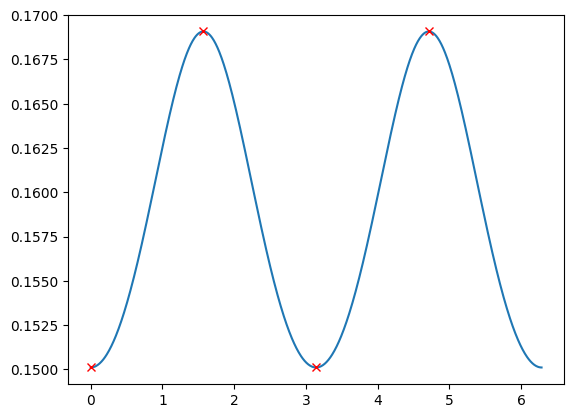

In [61]:
# In the paper they use the initial condition
rho_0_unnorm = lambda x: 1 + np.exp(-(np.sin(x - np.pi/2)**2) / 2) / np.sqrt(2 * np.pi)
x_grid = np.linspace(0, 2 * np.pi, 1000)
xf = np.linspace(0, 2 * np.pi, 4, endpoint=False)
h = (x_grid[1] - x_grid[0])
Z_0 = h * np.sum(rho_0_unnorm(x_grid))
print(Z_0)
plt.plot(x_grid, rho_0_unnorm(x_grid)/Z_0)
plt.plot(xf, rho_0_unnorm(xf) / Z_0, 'x', color='red')


0.44027928364479185


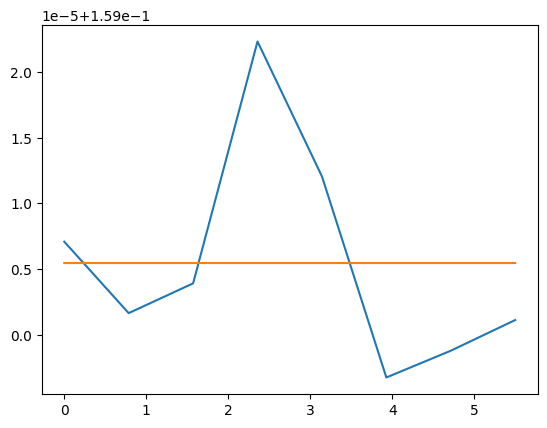

In [ ]:
# First I'll try a simple implementation to see if I can get at least get a feel for what
# the thing should feel like

# Initial setup things
seed = 42
N = 10000
rng = np.random.default_rng(seed)
batch_size = 1000
l = 1
Z_0 = 1 / 8.273782635069178 # normalisation constant
rho_0 = lambda x: Z_0 * (1 + np.exp(-(np.sin(x - np.pi/2)**2) / 2) / np.sqrt(2 * np.pi))
N_particles = 2 * 10**6
phi_fn = lambda x: np.cos(x)

# FD Parameters
lam = 0.25
nf = 2**(l+2) # number of cells
hf = 2 * np.pi / nf
dtf = lam * hf**2
timesteps_f = nf**2 # this corresponds to a total time T = pi**2.

if l > 0:
    nc = nf // 2
    hc = 2 * np.pi / nc
    dtc = lam * hc**2
    timesteps_c = nc**2
    xc = np.linspace(0, 2 * np.pi, nc, endpoint=False)

xf = np.linspace(0, 2 * np.pi, nf, endpoint=False) # ensure endpoint excluded for periodic boundary conditions
std_f = np.sqrt(dtf / hf)
sum1 = np.zeros(4)
sum2 = np.zeros(2)

# begin stepping
for N1 in range(0, N, batch_size):
    N2 = min(batch_size, N - N1)
    rho_barf = rho_0(xf) # I will need to update E[rho]. At t = 0 this is initial conditions.
    rho_f = np.tile(rho_barf, (N2, 1)).T
    
    if l == 0:
        for _ in range(timesteps_f):
            # calculate components of update
            sqrt_rho = np.sqrt(np.maximum(rho_f, 0))
            dW = std_f * rng.standard_normal((nf, N2))
            flux = sqrt_rho * dW
            divergence = (np.roll(flux, -1, axis=0) - np.roll(flux, 1, axis=0)) / (2*hf)
            
            laplacian = lam * (np.roll(rho_f, -1, axis=0) - 2 * rho_f + np.roll(rho_f, 1, axis=0)) / 2
            rho_f += laplacian + divergence / np.sqrt(N_particles)
            rho_barf += lam * (np.roll(rho_barf, -1, axis=0) - 2 * rho_barf + np.roll(rho_barf, 1, axis=0)) / 2

        deviation = rho_f - rho_barf[:, np.newaxis]
        phi_valsf = phi_fn(xf)
        inner_products = hf * np.sum(deviation * phi_valsf[:, np.newaxis], axis=0)
        Pf = N_particles * inner_products**2
        Pc = np.zeros(N2)

    else:
        rho_barc = rho_0(xc)
        rho_c = np.tile(rho_barc, (N2, 1)).T
        for _ in range(timesteps_c):
            dWc = np.zeros((nc, N2))
            for _ in range(4):
                sqrt_rho = np.sqrt(np.maximum(rho_f, 0))
                dWf = std_f * rng.standard_normal((nf, N2))
                flux = sqrt_rho * dWf
                divergence = (np.roll(flux, -1, axis=0) - np.roll(flux, 1, axis=0)) / (2 * hf)

                laplacian = lam * (np.roll(rho_f, -1, axis=0) - 2 * rho_f + np.roll(rho_f, 1, axis=0)) / 2
                rho_f += laplacian + divergence / np.sqrt(N_particles)
                rho_barf += lam * (np.roll(rho_barf, -1, axis=0) - 2 * rho_barf + np.roll(rho_barf, 1, axis=0)) / 2

                # Right most Nearest neighbours coupling
                dWc += dWf[::2, :] + dWf[1::2, :]
            
            dWc *= 0.5
            sqrt_rho = np.sqrt(np.maximum(rho_c, 0))
            flux = sqrt_rho * dWc
            divergence = (np.roll(flux, -1, axis=0) - np.roll(flux, 1, axis=0)) / (2 * hc)
            
            laplacian = lam * (np.roll(rho_c, -1, axis=0) - 2 * rho_c + np.roll(rho_c, 1, axis=0)) / 2
            rho_c += laplacian + divergence / np.sqrt(N_particles)
            rho_barc += lam * (np.roll(rho_barc, -1, axis=0) - 2 * rho_barc + np.roll(rho_barc, 1, axis=0)) / 2

        deviation = rho_f - rho_barf[:, np.newaxis]
        phi_vals = phi_fn(xf)
        inner_products = hf * np.sum(deviation * phi_vals[:, np.newaxis], axis=0)
        Pf = N_particles * inner_products**2

        deviation = rho_c - rho_barc[:, np.newaxis]
        phi_vals = phi_fn(xc)
        inner_products = hc * np.sum(deviation * phi_vals[:, np.newaxis], axis=0)
        Pc = N_particles * inner_products**2
    
    diff = Pf - Pc
    sum1[0] += np.sum(diff)
    sum1[1] += np.sum(diff**2)
    sum1[2] += np.sum(diff**3)
    sum1[3] += np.sum(diff**4)
    sum2[0] += np.sum(Pf)
    sum2[1] += np.sum(Pf**2)

        


# now calculate QoI
# diff = rho - rho_bar[:, np.newaxis]
# phi_vals = phi_fn(xf)
# inner_products = hf * np.sum(diff * phi_vals[:, np.newaxis], axis=0)
# Pf = N_particles * inner_products**2


plt.plot(xf, np.mean(rho_f, axis=1))
plt.plot(xf, rho_barf)
print(sum2[0])






In [86]:
a = np.array([[1,2,3,4],
             [4,3,2,1]]).T
b = np.array([1,2,1,2])
print(a, b)
a - b[:, np.newaxis]

[[1 4]
 [2 3]
 [3 2]
 [4 1]] [1 2 1 2]


array([[ 0,  3],
       [ 0,  1],
       [ 2,  1],
       [ 2, -1]])

In [97]:
a = np.array([[1,2,3,4], [4,3,2,1], [9,8,7,6], [5,6,7,8]]).T
print(a)
print(a[::2,:] + a[1::2,:])

[[1 4 9 5]
 [2 3 8 6]
 [3 2 7 7]
 [4 1 6 8]]
[[ 3  7 17 11]
 [ 7  3 13 15]]
